In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("measurements.csv")

In [3]:
df.head()

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28,5,26,"21,5",12,NaN,E10,0,0,0,45,E10
1,12,"4,2",30,"21,5",13,NaN,E10,0,0,0,NaN,NaN
2,"11,2","5,5",38,"21,5",15,NaN,E10,0,0,0,NaN,NaN
3,"12,9","3,9",36,"21,5",14,NaN,E10,0,0,0,NaN,NaN
4,"18,5","4,5",46,"21,5",15,NaN,E10,0,0,0,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   distance       388 non-null    object
 1   consume        388 non-null    object
 2   speed          388 non-null    int64 
 3   temp_inside    376 non-null    object
 4   temp_outside   388 non-null    int64 
 5   specials       93 non-null     object
 6   gas_type       388 non-null    object
 7   AC             388 non-null    int64 
 8   rain           388 non-null    int64 
 9   sun            388 non-null    int64 
 10  refill liters  13 non-null     object
 11  refill gas     13 non-null     object
dtypes: int64(5), object(7)
memory usage: 36.5+ KB


In [5]:
df["specials"].value_counts()

rain                  32
sun                   27
AC rain                9
ac                     8
AC                     6
snow                   3
sun ac                 3
half rain half sun     1
AC sun                 1
ac rain                1
AC snow                1
AC Sun                 1
Name: specials, dtype: int64

## Preprocessing

In [6]:
df = df.drop(columns = ["specials", "refill liters", "refill gas"], axis = 1)

In [7]:
df["distance"] = df["distance"].str.replace(",", ".")
df["consume"] = df["consume"].str.replace(",", ".")
df["temp_inside"] = df["temp_inside"].str.replace(",", ".")

In [8]:
dt = {"distance" : "float64", 
      "consume" : "float64",
      "temp_inside": "float64",
      "temp_outside": "float64"
     }

df = df.astype(dt)

In [9]:
df["temp_inside"] = df["temp_inside"].fillna(df["temp_inside"].median())

In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["gas_type"] = le.fit_transform(df["gas_type"])

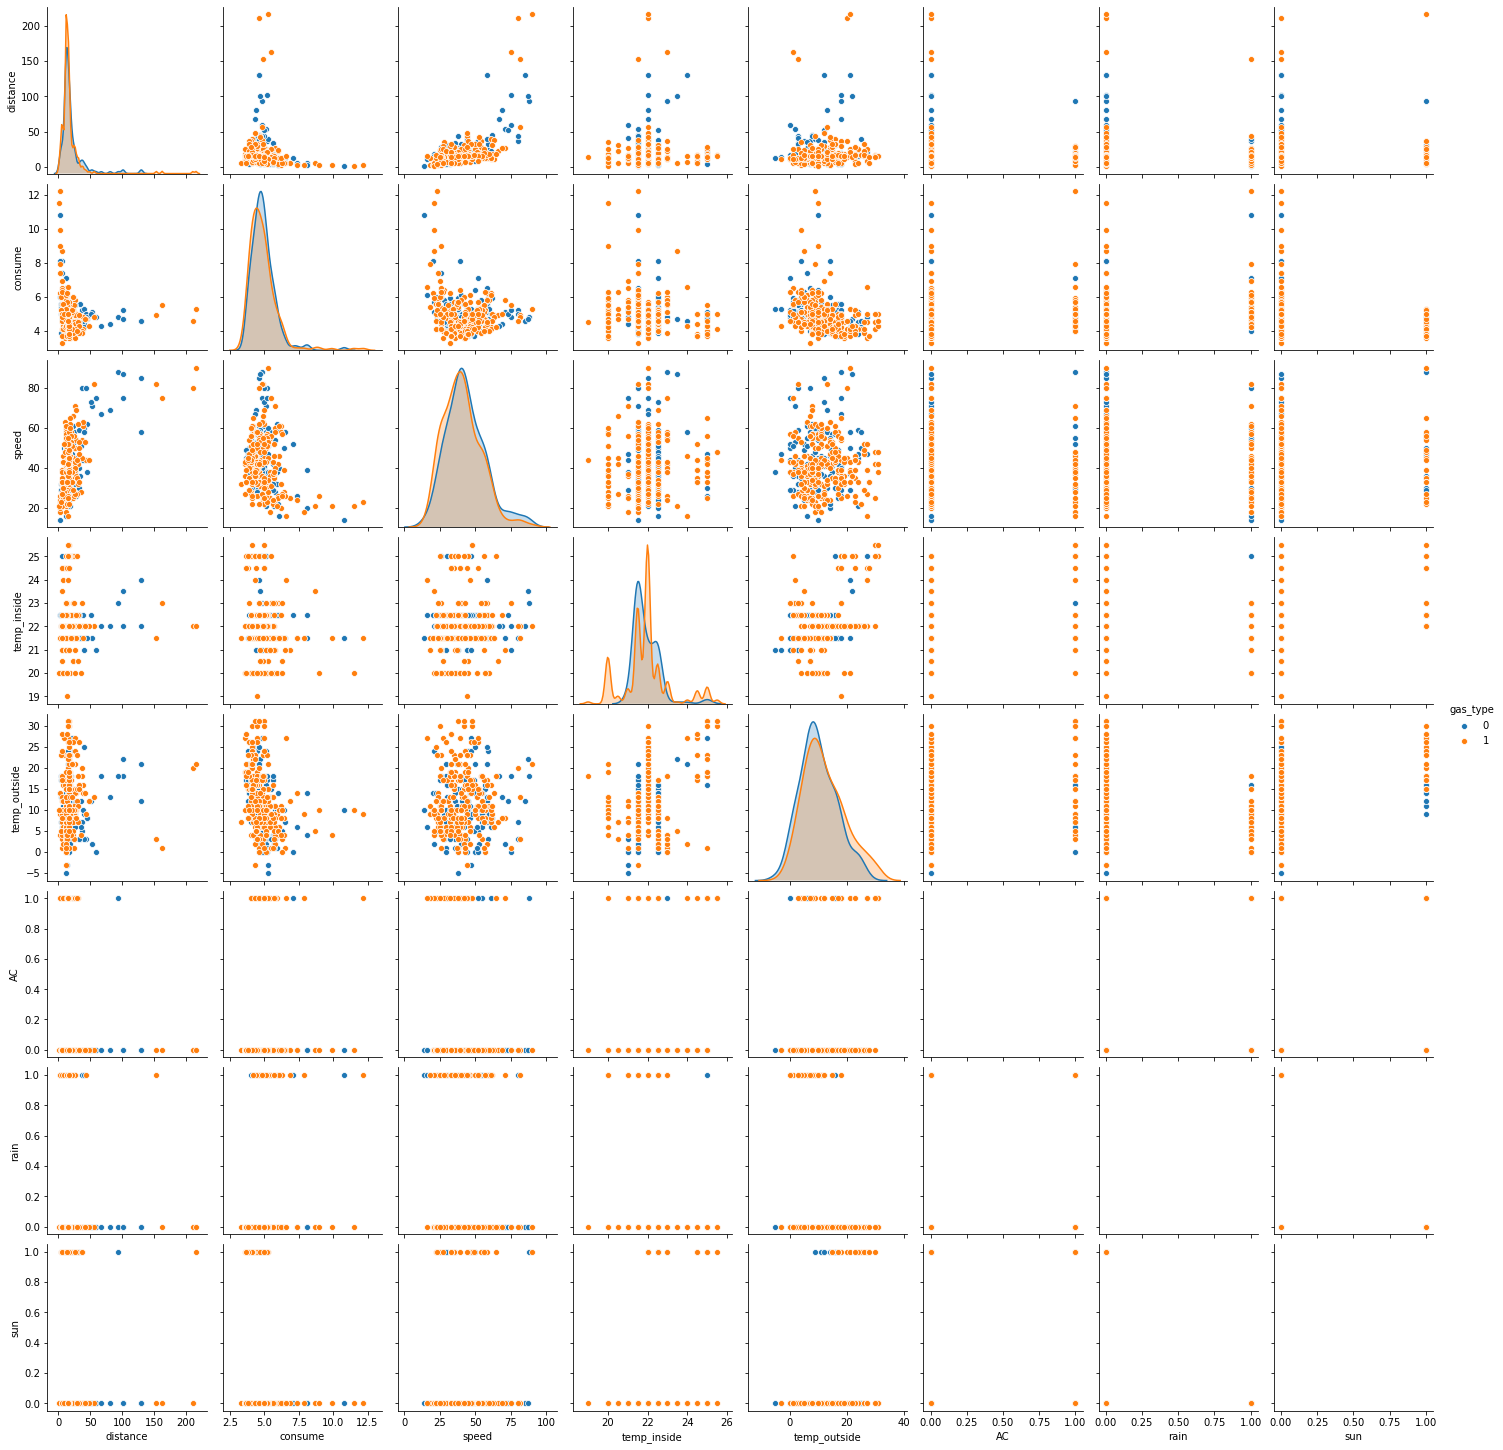

In [11]:
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
%matplotlib inline
sns.pairplot(df, hue = "gas_type")

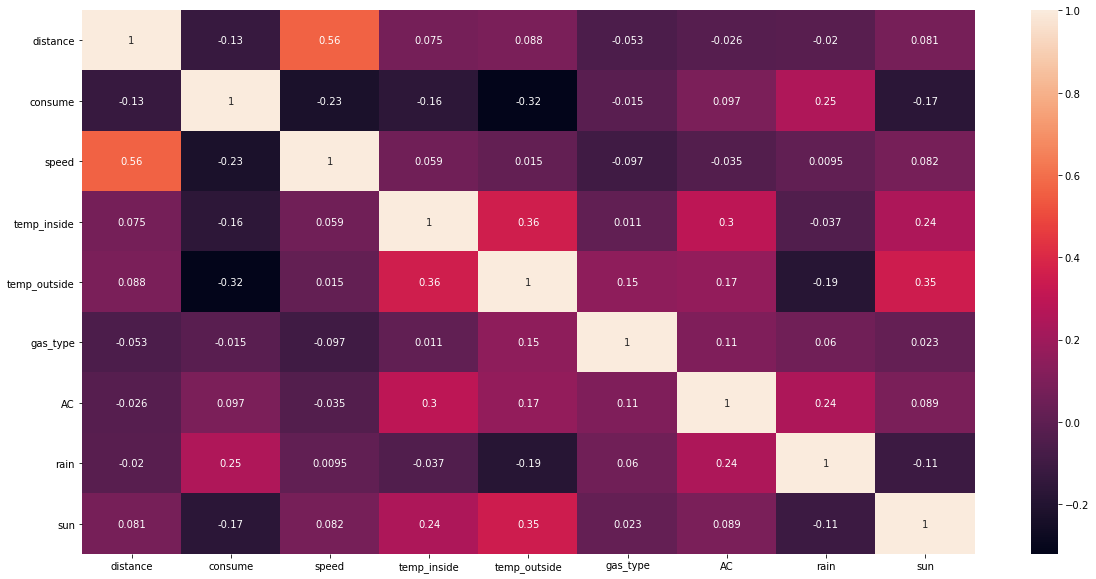

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr(), annot = True)

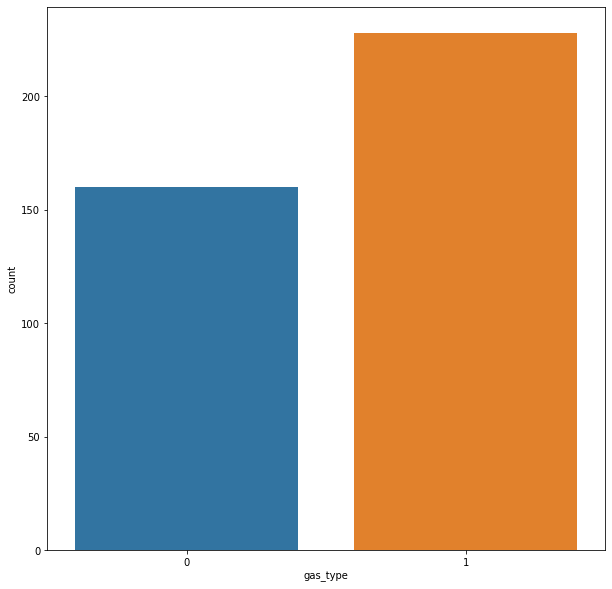

In [13]:
plt.figure(figsize = (10, 10))
sns.countplot(df["gas_type"])

In [14]:
from sklearn.model_selection import train_test_split

'X' и 'y' для классификации

In [15]:
X_classf = df.drop("gas_type", axis = 1)
y_classf = df["gas_type"].values

'X' и 'y' для регрессии

In [16]:
X_regress = df.drop("distance", axis = 1)
y_regress = df["distance"].values

Разделение для классификации

In [17]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_classf, y_classf, test_size = 0.1, shuffle = True)

Разделение для регрессии

In [18]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_regress, y_regress, test_size = 0.1, shuffle = True)

- XGBClassifier - подойдёт для этого набора данных, мы сможем посмотреть на наиболее важные признаки, влияющие на нашу модель
- KNeighborsClassifier - хороший метод для работы с малым количеством данных
- DecisionTreeClassifier - простое дерево, которое подойдёт под нащу модель

In [19]:
from xgboost import XGBClassifier, plot_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

### XGBClassifier

In [20]:
estims = [100, 200, 300]
train_score_xgb = []
test_score_xgb = []
for est in estims:
    xgb = XGBClassifier(n_estimators = est, verbosity = 1)
    xgb.fit(X_train_c, y_train_c)
    train_score_xgb.append(xgb.score(X_train_c, y_train_c))
    test_score_xgb.append(xgb.score(X_test_c, y_test_c))
    print(classification_report(y_test_c, xgb.predict(X_test_c)))

[16:29:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.79      0.65      0.71        23
           1       0.60      0.75      0.67        16

    accuracy                           0.69        39
   macro avg       0.69      0.70      0.69        39
weighted avg       0.71      0.69      0.69        39

[16:29:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

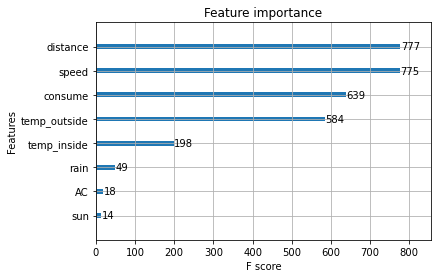

In [21]:
plot_importance(xgb)

In [22]:
print(train_score_xgb)
print(test_score_xgb)

[1.0, 1.0, 1.0]
[0.6923076923076923, 0.717948717948718, 0.7435897435897436]


### KNeighborsClassifier

In [23]:
neighbors = [3,6,9]
kn_test_score = []
kn_train_score = []
for neigh in neighbors:
    kn = KNeighborsClassifier(n_neighbors = neigh, n_jobs = -1)
    kn.fit(X_train_c, y_train_c)
    kn_train_score.append(kn.score(X_train_c, y_train_c))
    kn_test_score.append(kn.score(X_test_c, y_test_c))

In [24]:
print(kn_train_score)
print(kn_test_score)
print(classification_report(y_test_c, kn.predict(X_test_c)))

[0.7879656160458453, 0.7306590257879656, 0.7134670487106017]
[0.48717948717948717, 0.5128205128205128, 0.46153846153846156]
              precision    recall  f1-score   support

           0       0.60      0.26      0.36        23
           1       0.41      0.75      0.53        16

    accuracy                           0.46        39
   macro avg       0.51      0.51      0.45        39
weighted avg       0.52      0.46      0.43        39



### Decision Tree

In [25]:
dt = DecisionTreeClassifier()
dt.fit(X_train_c, y_train_c)
print(dt.score(X_train_c, y_train_c))
print(dt.score(X_test_c, y_test_c))
print(classification_report(y_test_c, dt.predict(X_test_c)))

1.0
0.5897435897435898
              precision    recall  f1-score   support

           0       0.68      0.57      0.62        23
           1       0.50      0.62      0.56        16

    accuracy                           0.59        39
   macro avg       0.59      0.60      0.59        39
weighted avg       0.61      0.59      0.59        39



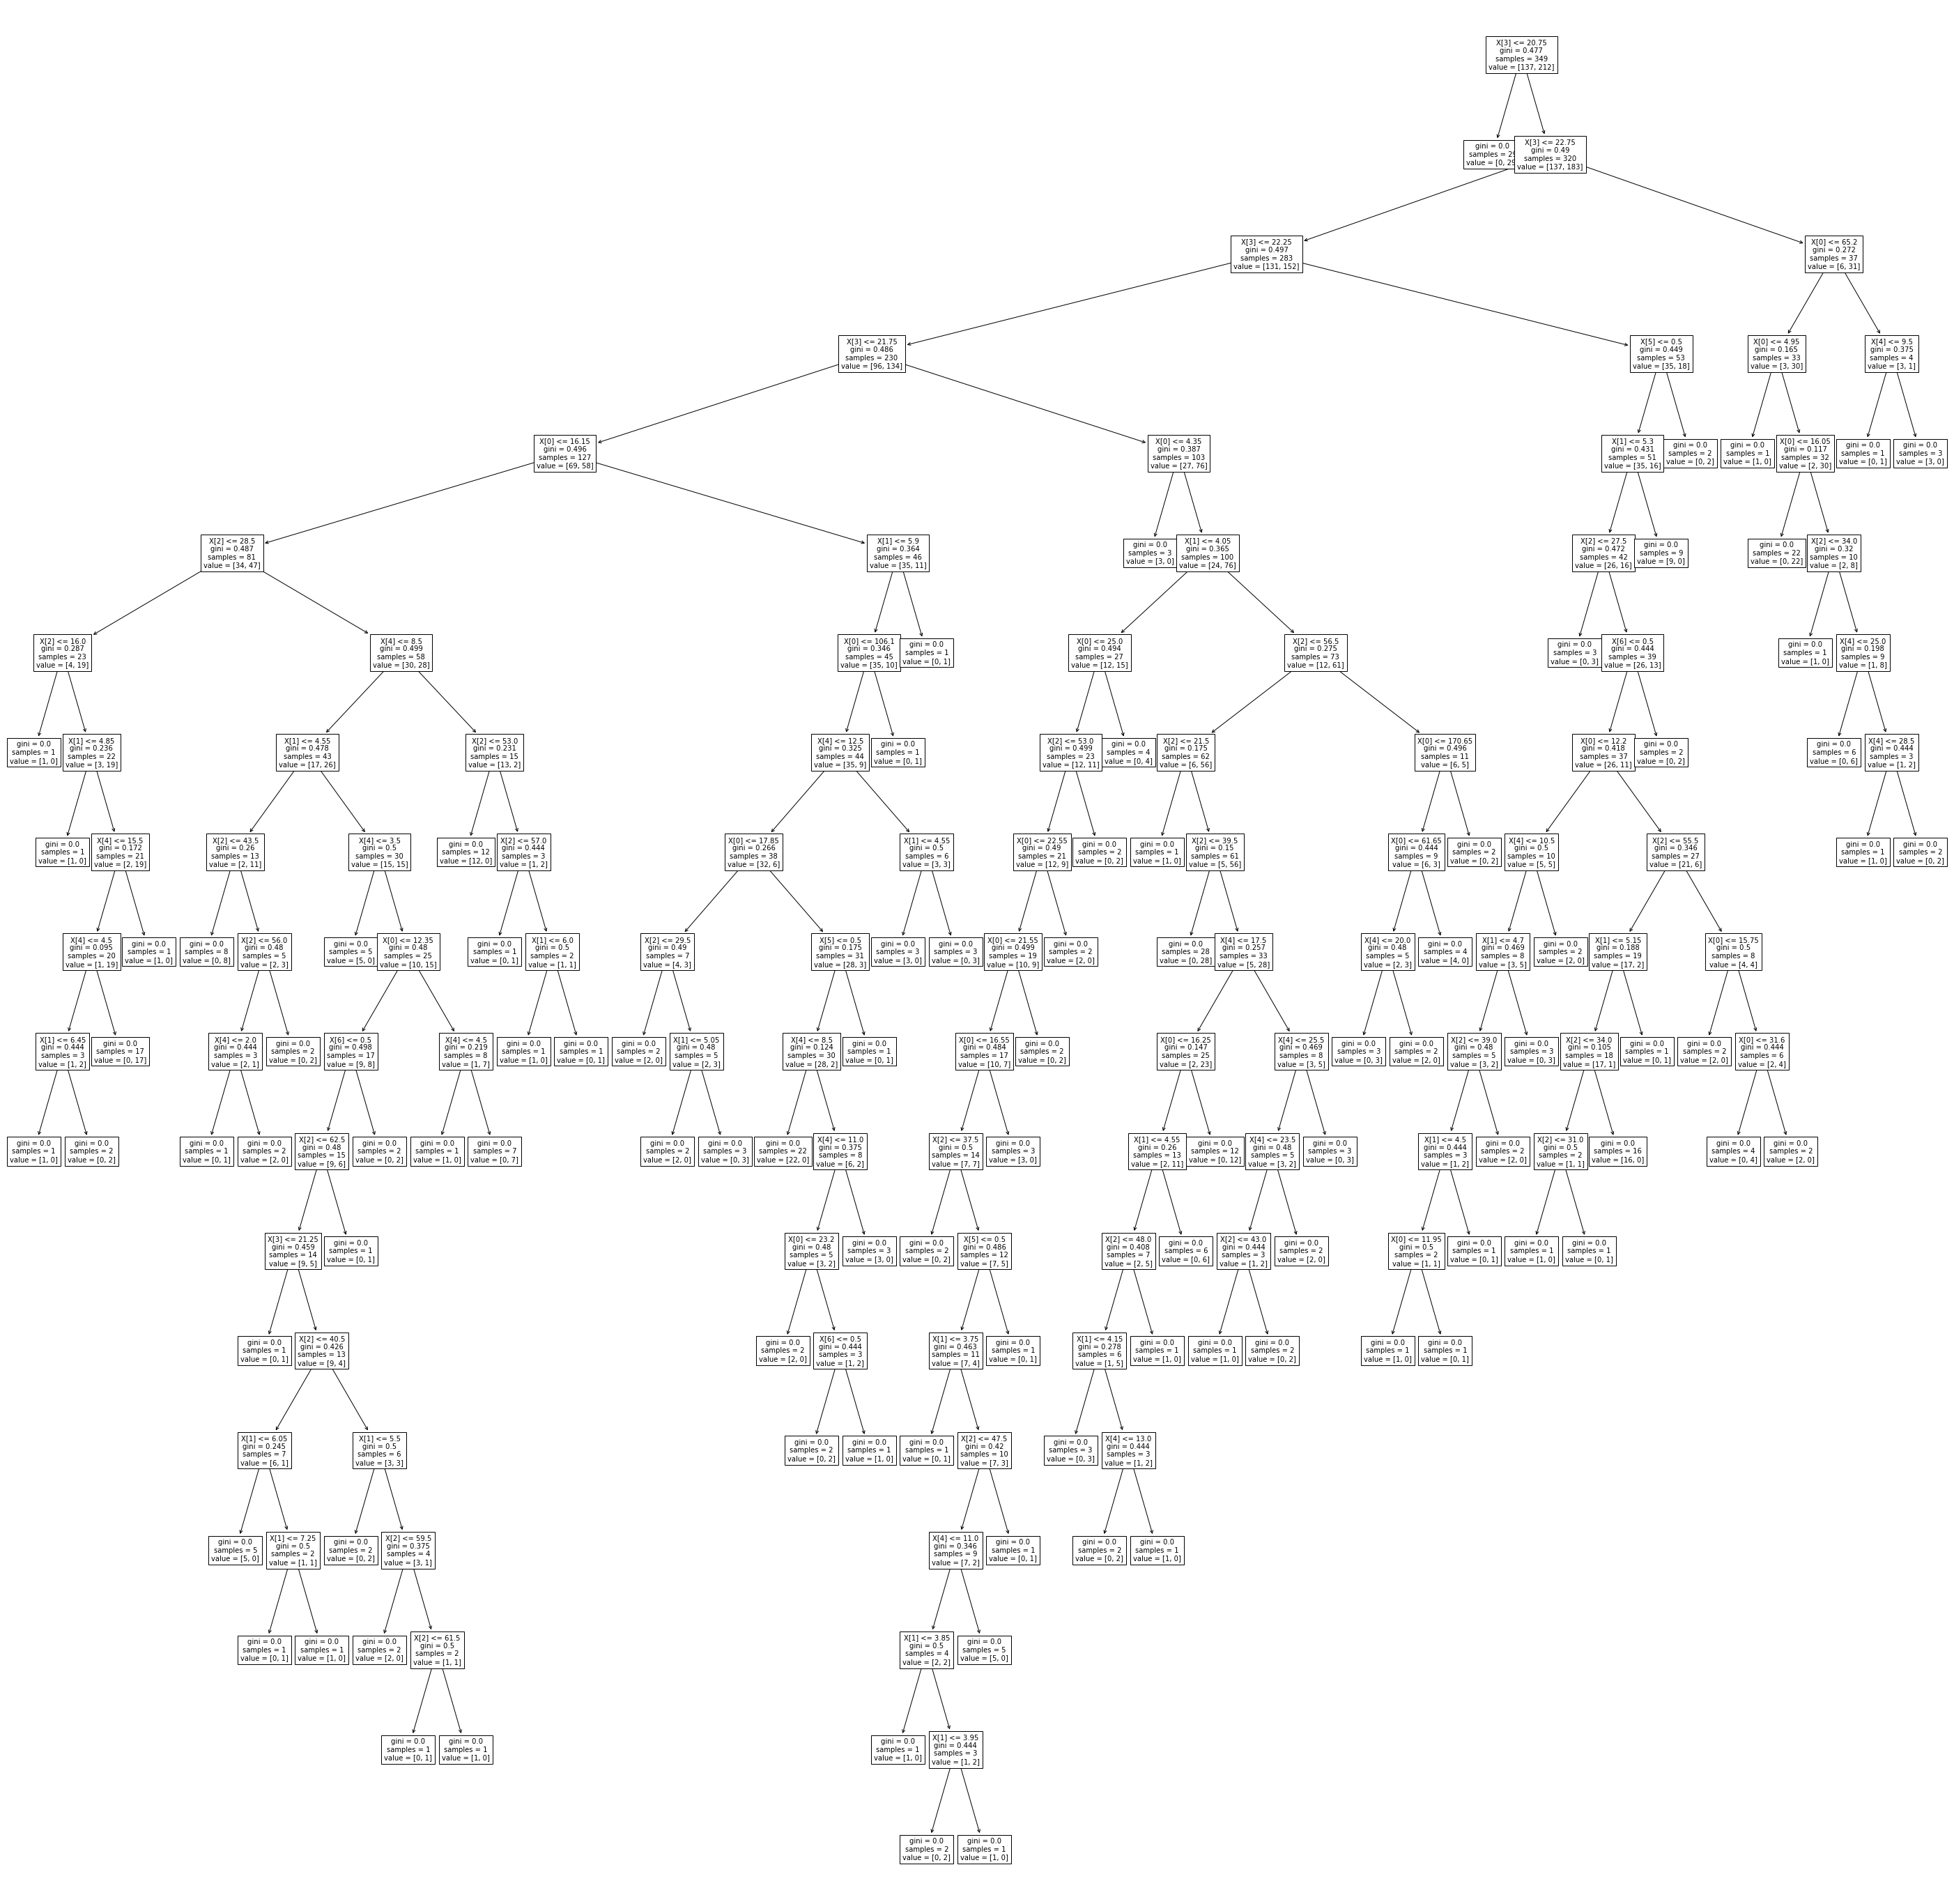

In [31]:
from sklearn.tree import plot_tree
plt.figure(figsize = (50,50))
plot_tree(dt, fontsize = 10)
plt.show()

- Наилучшей моделью оказался классификатор `XGBoost`

In [37]:
from sklearn.linear_model import Ridge, LinearRegression, SGDRegressor
from sklearn.ensemble import GradientBoostingRegressor

### LinearRegression

In [33]:
lr = LinearRegression(n_jobs = -1)
lr.fit(X_train_r, y_train_r)

LinearRegression(n_jobs=-1)

In [34]:
lr.score(X_test_r, y_test_r)

0.3631701300553627

### SGDRegressor

In [38]:
sgd = SGDRegressor()

In [39]:
sgd.fit(X_train_r, y_train_r)

SGDRegressor()

In [42]:
sgd.score(X_test_r, y_test_r)

-1.4041094910076717e+19

### GradientBoosting

In [43]:
grb = GradientBoostingRegressor(n_estimators=100, verbose = 3)
grb.fit(X_test_r, y_test_r)

      Iter       Train Loss   Remaining Time 
         1         360.9841            1.48s
         2         301.2280            0.78s
         3         251.0473            0.55s
         4         211.5399            0.43s
         5         178.0486            0.36s
         6         150.9206            0.30s
         7         129.4587            0.27s
         8         111.2502            0.23s
         9          96.4427            0.21s
        10          83.0947            0.19s
        11          71.7132            0.18s
        12          62.7215            0.16s
        13          56.0977            0.15s
        14          49.7879            0.14s
        15          44.2341            0.14s
        16          40.5220            0.13s
        17          36.7713            0.12s
        18          33.3878            0.12s
        19          31.2900            0.11s
        20          29.0302            0.11s
        21          26.8481            0.11s
        2

GradientBoostingRegressor(verbose=3)

In [44]:
grb.score(X_test_r, y_test_r)

0.9985722624559993

In [45]:
X_regress

,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun
0,5.0,26,21.5,12.0,0,0,0,0
1,4.2,30,21.5,13.0,0,0,0,0
2,5.5,38,21.5,15.0,0,0,0,0
3,3.9,36,21.5,14.0,0,0,0,0
4,4.5,46,21.5,15.0,0,0,0,0
...,...,...,...,...,...,...,...,...
383,3.7,39,24.5,18.0,1,0,0,0
384,4.3,38,25.0,31.0,1,1,0,0
385,3.8,45,25.0,19.0,1,0,0,0
386,4.6,42,25.0,31.0,1,1,0,0


In [46]:
import numpy as np
to_pred = np.array([[6.3, 55, 21.5, 15.0, 0, 1, 0, 0]])
grb_pred = grb.predict(to_pred)

In [47]:
grb_pred

array([16.67692031])

Была проведена нормализация данных, приведение к общему виду. Удалены нулевые значения, произведено обучение на 6 моделях. 

Итого, лучший результат прогнозирования показал `XGBoost`
 - Классификатор: 69%
 - Регрессор: 99%

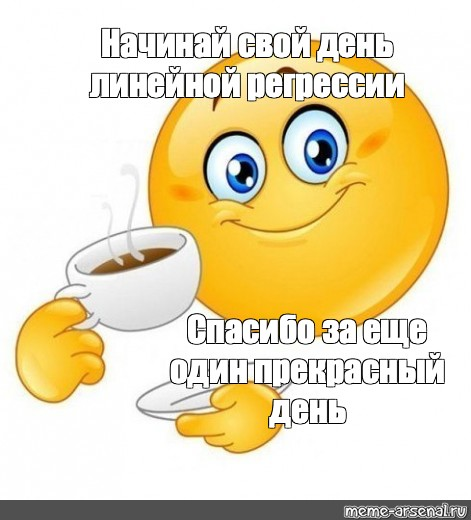